In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision

In [2]:
data_set = [(np.array([3,3]),1),(np.array([4,3]),1),(np.array([1,1]),-1)]

In [3]:
class Perception():
    def __init__(self, dim) -> None:
        # 构造函数
        # dim:   特征维度
        # w:     权重
        # b:     偏置项

        self.dim = dim
        self.w = np.zeros([dim])
        self.b = 0
    
    def train(self, data_set, epoch, learning_rate):
        # 训练模型

        for i in range(epoch):
            for (x,y) in data_set:
                if self.predict(x)*y <= 0:
                    self.w = self.w + learning_rate*x*y
                    self.b = self.b + learning_rate*y
            # 计算准确率
            acc = self.accuracy(data_set)
            print('epoch: ',i+1, 'accuracy: ', acc)
            # 早停条件
            if acc == 1:
                break
        print('Trining complete.')

    def predict(self, x):
        # 预测

        return np.sign(np.dot(self.w,x) + self.b)
    
    def accuracy(self, data_set):
        # 计算精度
        
        acc = 0
        for (x,y) in data_set:
            if self.predict(x)*y > 0:
                acc += 1
        return acc/len(data_set)

In [4]:
model = Perception(2)
model.train(
    data_set=data_set,
    epoch=10,
    learning_rate=0.01
)

epoch:  1 accuracy:  0.6666666666666666
epoch:  2 accuracy:  0.6666666666666666
epoch:  3 accuracy:  0.3333333333333333
epoch:  4 accuracy:  0.6666666666666666
epoch:  5 accuracy:  1.0
Trining complete.


In [5]:
xx = np.linspace(-1,5,100)
yy = (-model.w[0]*xx-model.b)/model.w[1]

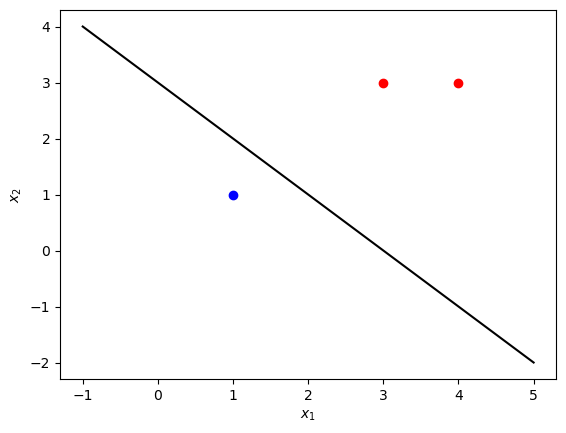

In [8]:
plt.plot(xx,yy,color = 'black')
for (x,y) in data_set:
    if y > 0:
        plt.scatter(x[0],x[1],color='r')
    else:
        plt.scatter(x[0],x[1],color='b')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.savefig('./figure/perception1.png',dpi=600)

In [9]:
class PerceptionDual():
    def __init__(self, data) -> None:
        # 构造函数
        # data:     训练数据
        
        self.data = data
        self.N = len(data)
        self.x = np.array([xx for (xx,_) in data])
        self.y = np.array([yy for (_,yy) in data])
        self.alpha = np.zeros([self.N])
        self.b = 0
    
    def train(self, epoch, learning_rate):
        # 训练模型
        
        for i in range(epoch):
            for j in range(len(self.data)):
                if self.predict(self.data[j][0])*self.data[j][1] <= 0:
                    self.alpha[j] = self.alpha[j] + learning_rate
                    self.b = self.b + learning_rate*self.data[j][1]
            # 计算准确率
            acc = self.accuracy(self.data)
            print('epoch: ',i+1, 'accuracy: ', acc)
            # 早停条件
            if acc == 1:
                break
        print('Trining complete.')

    def predict(self, x):
        # 预测
        return np.sign(np.dot(np.dot(self.x,x),self.alpha*self.y) + self.b)
    
    def accuracy(self, data_set):
        # 计算精度

        acc = 0
        for (x,y) in data_set:
            if self.predict(x)*y > 0:
                acc += 1
        return acc/len(data_set)

In [10]:
model = PerceptionDual(data_set)
model.train(
    epoch=10,
    learning_rate=0.01
)

epoch:  1 accuracy:  0.6666666666666666
epoch:  2 accuracy:  0.6666666666666666
epoch:  3 accuracy:  0.3333333333333333
epoch:  4 accuracy:  0.6666666666666666
epoch:  5 accuracy:  1.0
Trining complete.


In [13]:
xx = np.linspace(-1,5,100)
w = np.sum(np.expand_dims(model.alpha*model.y,-1)*model.x,0)
yy = (-w[0]*xx-model.b)/w[1]

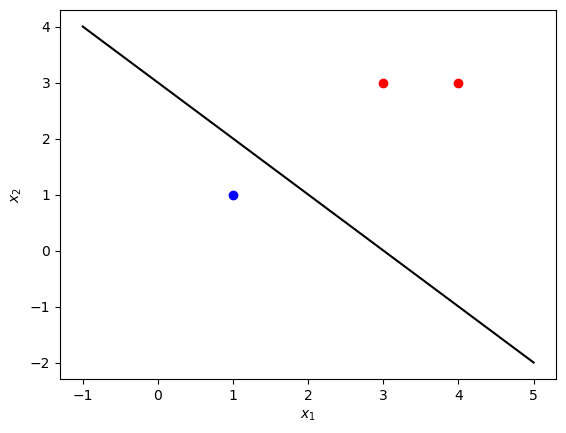

In [14]:
plt.plot(xx,yy,color = 'black')
for (x,y) in data_set:
    if y > 0:
        plt.scatter(x[0],x[1],color='r')
    else:
        plt.scatter(x[0],x[1],color='b')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.savefig('./figure/perception2.png',dpi=600)

In [15]:
data=torchvision.datasets.MNIST(
    root='MNIST',
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=True
)

In [16]:
train_data = data.train_data
train_label = data.train_labels

d:\Anaconda3\envs\py37cpu\lib\site-packages\torchvision\datasets\mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
d:\Anaconda3\envs\py37cpu\lib\site-packages\torchvision\datasets\mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


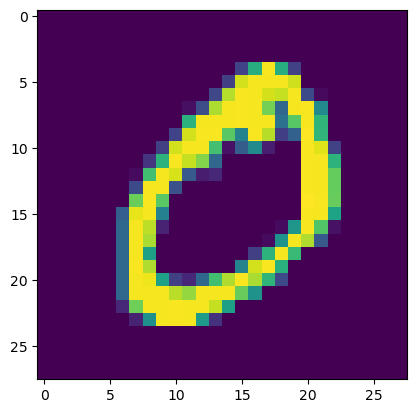

In [17]:
plt.imshow(train_data[1])

In [18]:
train_label[1]

tensor(0)

In [19]:
# 转化为二分类
data_set = []
for i in range(train_data.shape[0]):
    if train_label[i] < 5:
        y = 1
    else:
        y = -1
    data_set.append(
        (train_data[i].reshape([28**2]).numpy()/255,y)
    )

In [20]:
model = PerceptionDual(data_set[:1000])

In [21]:
model.train(
    epoch=30,
    learning_rate=0.001
)

epoch:  1 accuracy:  0.821
epoch:  2 accuracy:  0.849
epoch:  3 accuracy:  0.853
epoch:  4 accuracy:  0.83
epoch:  5 accuracy:  0.883
epoch:  6 accuracy:  0.884
epoch:  7 accuracy:  0.844
epoch:  8 accuracy:  0.884
epoch:  9 accuracy:  0.85
epoch:  10 accuracy:  0.889
epoch:  11 accuracy:  0.874
epoch:  12 accuracy:  0.852
epoch:  13 accuracy:  0.85
epoch:  14 accuracy:  0.888
epoch:  15 accuracy:  0.897
epoch:  16 accuracy:  0.889
epoch:  17 accuracy:  0.917
epoch:  18 accuracy:  0.88
epoch:  19 accuracy:  0.912
epoch:  20 accuracy:  0.909
epoch:  21 accuracy:  0.9
epoch:  22 accuracy:  0.912
epoch:  23 accuracy:  0.866
epoch:  24 accuracy:  0.932
epoch:  25 accuracy:  0.909
epoch:  26 accuracy:  0.819
epoch:  27 accuracy:  0.901
epoch:  28 accuracy:  0.921
epoch:  29 accuracy:  0.92
epoch:  30 accuracy:  0.923
Trining complete.


In [22]:
class Node():
    def __init__(self, value, data, label) -> None:
        # 构造函数
        # value:        节点的划分超平面参数
        # data:         落在超平面上的数据点
        # label:        落在超平面上的数据点对应的标签

        self.value = value
        self.data = data
        self.label = label
        self.left = None
        self.right = None
    
    def set_left(self, node):
        # 设置左子节点

        if node != None:
            self.left = node

    def set_right(self, node):
        # 设置右子节点

        if node != None:
            self.right = node

class KDTree():
    def __init__(self) -> None:
        # 构造函数
        # 用于存储KDTree，支持直接实例化对象时直接输入一个kd-树
        self.root = None
    
    def create(self, data, label, j = 0):
        # 递归构造平衡KD树

        num, k = data.shape
        if num == 0:
            return None
        else:
            l = j % k
            ind_sorted = np.argsort(data[:,l])
            ind_median = ind_sorted[num//2]
            value_ = int(np.median(data[ind_median,l]))
            data_ = data[data[:,l]==value_]
            label_ = label[data[:,l]==value_]
            node = Node(
                value=value_,
                data=data_,
                label=label_
            )
            node.set_left(
                self.create(
                    data=data[data[:,l]<value_],
                    label=label[data[:,l]<value_],
                    j=j+1
                )
            )
            node.set_right(
                self.create(
                    data=data[data[:,l]>value_],
                    label=label[data[:,l]>value_],
                    j=j+1
                )
            )
            if j == 0:
                self.root = node
            else:
                return node
    
    def search(self, x, j = 0, node = None):
        # 递归搜索KD树

        if self.root == None:
            print("You haven't created a KDTree yet.")
            return None
        if j == 0:
            node = self.root
        k = x.shape[0]
        l = j % k
        # 叶子节点停止条件
        if self.is_leaf(node):
            distance = np.linalg.norm(x-node.data,2,1)
            index = np.argmin(distance)
            return node.data[index], node.label[index]
        else:
            # 计算当前节点中的最近数据点
            distance = np.linalg.norm(x-node.data,2,1)
            min_distance = np.min(distance)
            index = np.argmin(distance)
            nearest = node.data[index]
            label = node.label[index]
            # 递归计算子节点的最近数据点，并比较
            if x[l] < node.value and node.left != None:
                nearest_, label_ = self.search(
                    x = x,
                    j = j+1,
                    node = node.left
                )
                if np.linalg.norm(x-nearest_,2) < min_distance:
                    nearest = nearest_
                    label = label_
            elif x[l] > node.value and node.right != None:
                nearest_, label_ = self.search(
                    x = x,
                    j = j+1,
                    node = node.right
                )
                if np.linalg.norm(x-nearest_,2) < min_distance:
                    nearest = nearest_
                    label = label_
            return nearest, label

    def is_leaf(self, node: Node):
        # 判断是否是叶子节点
        
        if node.left != None or node.right != None:
            return False
        else:
            return True

In [23]:
# 处理数据
data_num,dimx,dimy = train_data.shape
data = train_data.reshape([data_num,dimx*dimy])+torch.randint(0,10,[data_num,dimx*dimy])
label = train_label.unsqueeze(-1)

In [24]:
model = KDTree()
tree = model.create(
    data=data[:10000],
    label=label[:10000]
)

In [25]:
x = data[20000]
y,_ = model.search(x)

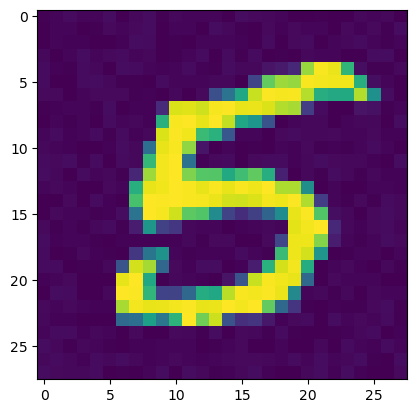

In [30]:
plt.imshow(x.reshape([dimx,dimy]))
plt.savefig('./figure/mnist_rel.png',dpi=600)

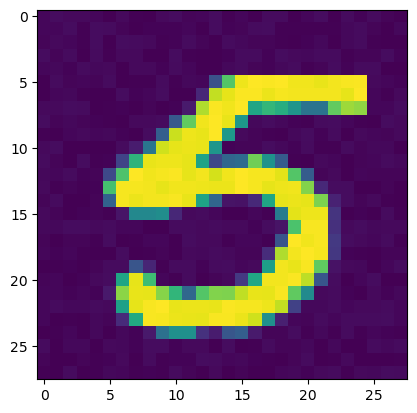

In [31]:
yy = y[:dimx*dimy].reshape([dimx,dimy])
plt.imshow(yy)
plt.savefig('./figure/mnist_pre.png',dpi=600)

In [28]:
k = 10000
acc = 0
data_test = data[-10000:]
label_test = label[-10000:]
for i in range(10000):
    data_rel = data_test[i]
    label_rel = label_test[i]
    data_pre,label_pre = model.search(data_rel)
    if label_pre == label_rel:
        acc += 1
acc /= 10000

In [29]:
acc

0.9038